#### IMDB

This notebook reads reviews from the IMDB movie review dataset. Each word is tokenized such that the 1,000 most frequent words are used as features to represent each review.

In [123]:
import pandas as pd
movies = pd.read_csv("review100.csv")

tokens=movies["movie review"].str.split()
sentiment=movies['sentiment']
tokenized=pd.concat([tokens,sentiment], axis=1)

word_freq=movies["movie review"].str.split().explode().value_counts()
word_freq=word_freq.head(1000)

for i in word_freq.index:
    tokenized.insert(loc=0,column=i,value=tokenized['movie review'].iloc[0:tokenized.shape[0]].str.contains(i, regex=False))  # add column with every word to left side of dataset, set value 1 if the movie review contains the word

tokenized=tokenized[tokenized.columns[::-1]]*1 #change bool value to 1 or 0
tokenized.insert(tokenized.shape[1],'label', 1*(tokenized['sentiment']=="positive"))
tokenized=tokenized.drop(['sentiment', 'movie review'],axis=1)

print(tokenized.shape)
tokenized.head()


(100, 1001)


,the,a,and,of,to,is,in,that,/><br,I,...,Jack,works,day,tests,Eyes,deeply,saying,(which,instead,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


20% of the dataset is set aside for testing. 

In [124]:
features=tokenized.iloc[:,:-1].values
labels=tokenized['label'].values

In [125]:
X_train, X_test, y_train, y_test=train_test_split(features, labels, test_size=0.2,stratify=labels, random_state=1)
mlpmovie = MLPClassifier(solver='sgd',learning_rate_init=.01, hidden_layer_sizes=500,random_state=42,activation='tanh',max_iter=3000)
mlpmovie.fit(X_train, y_train)
y_pred=mlpmovie.predict(X_test)
print("The accuracy of the 500 node network is", accuracy_score(y_test, y_pred))

The accuracy of the 500 node network is 0.75


A first attempt to increase the accuracy is done by calculating the information gain of each word/feature and dropping words with the least information gain.

In [126]:
entropy=-(((tokenized['label']==1).sum()/tokenized.shape[0])*np.log2((tokenized['label']==1).sum()/tokenized.shape[0])+(tokenized['label']==0).sum()/tokenized.shape[0]*np.log2((tokenized['label']==0).sum()/tokenized.shape[0]))

worddata=tokenized.iloc[:,2:] #remove movie review and sentiment
condentr_word=[]
for word in worddata.drop('label', axis=1).columns:
    totwith=(worddata[word]==1).sum() #total number of reviews with word
    totwithout=(worddata[word]==0).sum() #total number of reviews without word

    withpos=worddata[(worddata[word]==1) & (worddata['label']==1)].shape[0] #number of positive labels with word
    withneg=worddata[(worddata[word]==1) & (worddata['label']==0)].shape[0] #number of negative labels with word
  
    if withpos/totwith and withneg/totwith != 0:
        condsubsetwith = -(withpos/totwith * np.log2(withpos/totwith) + withneg/totwith*np.log2(withneg/totwith))
    elif withneg == 0:
        condsubsetwith = -((withpos/totwith) * np.log2(withpos/totwith))
    elif withpos == 0:
        condsubsetwith = -((withneg/totwith)*np.log2(withneg/totwith))
    elif totwith == 0:
        condsubsetwith=0

    withoutpos=worddata[(worddata[word]==0) & (worddata['label']==1)].shape[0] #number of positive labels without word
    withoutneg=worddata[(worddata[word]==0) & (worddata['label']==0)].shape[0] #number of negative labels without word

    if withoutpos/totwithout and withoutneg/totwithout != 0:
        condsubsetwithout = -(withoutpos/totwithout * np.log2(withoutpos/totwithout)+withoutneg/totwithout * np.log2(withoutneg/totwithout))
    elif withoutneg == 0:
        condsubsetwithout = -(withoutpos/totwithout * np.log2(withoutpos/totwithout))
    elif withoutpos == 0:
        condsubsetwithout = -(withoutneg/totwithout*np.log2(withoutneg/totwithout))
    elif totwithout == 0:
        condsubsetwithout=0

    condetr = (totwith*condsubsetwith)/(totwithout+totwith) + (totwithout*condsubsetwithout)/(totwithout+totwith)
    condentr_word.append(condetr)
    
infogain=worddata.drop('label', axis=1)

infogain.loc[len(infogain)]=np.array([entropy]*len(condentr_word))-np.array(condentr_word) #calculating info gain, set to bottom row

infogain=infogain.sort_values(infogain.last_valid_index(), axis=1, ascending=False)


In [127]:
infogain

,love,takes,upon,times,may,man,could,later,New,unique,...,Sir,main,on.,An,"characters,",that's,nominated,black,death,battle
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
97,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
wordswithinfo=infogain.drop(infogain.columns[infogain.iloc[-1,:]<0.005],axis=1) #drop any features with infogain lower than .005
wordswithinfo=wordswithinfo.iloc[:-1,:] #delete info gain row
features_info=wordswithinfo.iloc[:,:-1].values
X_train_info, X_test_info, y_train, y_test=train_test_split(features_info, labels, test_size=0.2,stratify=labels, random_state=1)
mlpmovie_info = MLPClassifier(solver='sgd',learning_rate_init=.01, hidden_layer_sizes=500,random_state=42,activation='tanh',max_iter=3000)
mlpmovie_info.fit(X_train_info, y_train)
y_pred_info=mlpmovie_info.predict(X_test_info)
print("The accuracy of the 500 node network with info gain filtered data is", accuracy_score(y_test, y_pred_info))

The accuracy of the 500 node network with info gain filtered data is 0.8


Many of the feature words have 0 information gain. By removing the words with low information gain, it should reduce the noise in the network and allow the network to focus only on what is important for better training. 

It was implemented by calculating the conditional entropy of each word, then subtracting that from the entropy of the whole dataset. This gives the information gain for each word in the feature space. Then the words with info gain lower than .005 were dropped from the data, and the model was trained again with the same parameters.

After filtering out features with no information gain, the false positive rate of the model has decreased. This increases the overall accuracy of the model by 5% from 75% to 80%. 

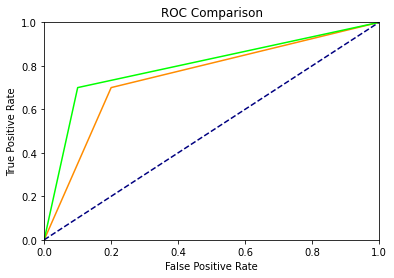

AUC value before filtering is 0.75
AUC value after filtering for info gain is 0.80


In [129]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
fpr_info, tpr_info, thresholds = metrics.roc_curve(y_test, y_pred_info, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Not filtered')
plt.plot(fpr_info, tpr_info, color='lime', label='Info gain filtered')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.show()

aucscore=roc_auc_score(y_test, y_pred)
aucscore_info=roc_auc_score(y_test, y_pred_info)
print("AUC value before filtering is %.2f" % aucscore)
print("AUC value after filtering for info gain is %.2f" % aucscore_info)

How many words can we remove before performance stops improving and starts decreasing? Implemented below is using the info gain filter to remove any words with info gain less than .007, which removes an additional 49 words from the bottom of the info gain list. The original list was 1000 words, an info gain threshold of .005 reduces it to 506 words, and an info gain threshold of .007 reduces it to 457 words. This increases the AUC from 80% to 90%. It drops back down to 85% AUC when all words with <.01 info gain are filtered. The AUC starts to decrease when the features are filtered too much and there are not enough words in the dataset. 

Increasing the size of the hidden layer did not improve the performance of the network, nor did adding additional layers. In fact, adding additional layers caused performance to drop. This demonstrates that regardless of the size and complexity of the model, the quality of the data is of the highest importance for good performance. 

The accuracy of the 500 node network with more info gain filtered data is 0.9


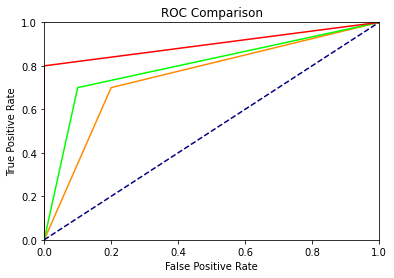

In [131]:
wordswithmoreinfo=infogain.drop(infogain.columns[infogain.iloc[-1,:]<0.007],axis=1) #drop any features with infogain lower than .007
wordswithmoreinfo=wordswithmoreinfo.iloc[:-1,:] #delete info gain row
features_moreinfo=wordswithmoreinfo.iloc[:,:-1].values
X_train_moreinfo, X_test_moreinfo, y_train, y_test=train_test_split(features_moreinfo, labels, test_size=0.2,stratify=labels, random_state=1)
mlpmovie_more = MLPClassifier(solver='sgd',learning_rate_init=.01, hidden_layer_sizes=(500),random_state=42,activation='tanh',max_iter=3000)
mlpmovie_more.fit(X_train_moreinfo, y_train)
y_pred_more=mlpmovie_more.predict(X_test_moreinfo)
print("The accuracy of the 500 node network with more info gain filtered data is", accuracy_score(y_test, y_pred_more))

fpr_more, tpr_more, thresholds = metrics.roc_curve(y_test, y_pred_more, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Not filtered')
plt.plot(fpr_info, tpr_info, color='lime', label='Info gain filtered')
plt.plot(fpr_more, tpr_more, color='red', label='More info gain filtered')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.show()